In [130]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from skimage.transform import resize
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d
from skimage import util
from skimage.restoration import richardson_lucy as rl



In [3]:

def blur(img, mode = 'box', kernel_size = 3):
    # mode = 'box' or 'gaussian' or 'motion'
    dummy = np.copy(img)
    if mode == 'box':
        h = np.ones((kernel_size, kernel_size)) / kernel_size ** 2
    elif mode == 'gaussian':
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
    elif mode == 'motion':
        h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

In [4]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

In [ ]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    noisy_img = img + gauss
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

In [5]:
def inverse_filter(img, kernel):
    # Normalize the kernel to ensure it sums to 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image and perform Fourier transform
    dummy = np.copy(img)
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel and pad it to match the image's size
    kernel = fft2(kernel, s=img.shape)
    
    # Avoid division by zero or very small values in the kernel
    epsilon = 1e-8
    kernel[np.abs(kernel) < epsilon] = epsilon  # Set small values to epsilon
    
    # Apply the inverse filter in the frequency domain (divide image by kernel)
    dummy = dummy / kernel
    
    # Perform the inverse Fourier transform to bring the image back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    return dummy  # Return the restored image

 

In [6]:
def trunc_filter(img, kernel, radius):

    
    # Initialize the restored image array with the same shape as the input image
    restored = np.zeros_like(img)
    
    # Perform FFT on the grayscale image
    G = np.fft.fftshift(np.fft.fft2(img))  # FFT of the image
    
    # Pad the kernel to match the size of the image
    h_padded = np.zeros(img.shape)
    h_padded[:kernel.shape[0], :kernel.shape[1]] = np.copy(kernel)
    H = np.fft.fftshift(np.fft.fft2(h_padded))  # FFT of the padded kernel

    # Normalize the Fourier transforms
    H_norm = H / np.abs(H.max())
    G_norm = G / np.abs(G.max())
    
    # Apply truncation in the frequency domain
    F_temp = G_norm / H_norm
    F_norm = F_temp / np.abs(F_temp.max())
    
    # Rescale to original scale
    F_hat = F_norm * np.abs(G.max())
    
    # Create a mask for the inner and outer regions based on the specified radius
    circle_img = np.zeros(img.shape)
    cv2.circle(circle_img, (img.shape[0] // 2, img.shape[1] // 2), radius, 1, thickness=-1)  # Inner circle
    inner_F_hat = circle_img * F_hat  # Apply mask to the filtered result
    circle_img = 1 - circle_img  # Invert mask for the outer region
    outer_G = circle_img * G  # Apply mask to the original FFT

    # Inverse FFT to obtain the restored image
    f_hat = np.fft.ifft2(np.fft.ifftshift(inner_F_hat + outer_G))  
    restored = np.abs(f_hat)  # Store the result

    return restored  # Return the restored image


    

In [7]:
def wiener_filter(img, kernel, K):
    # Normalize the kernel by ensuring its sum is 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image to avoid modifying the original
    dummy = np.copy(img)
    
    # Perform Fourier transform on the image to convert it to the frequency domain
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel, padded to match the image size
    kernel = fft2(kernel, s=img.shape)
    
    # Apply Wiener filtering: conjugate the kernel and use it with the regularization term (K)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    
    # Apply the filter by multiplying the transformed image with the filtered kernel
    dummy = dummy * kernel
    
    # Perform inverse Fourier transform to bring the result back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    # Return the filtered image
    return dummy


In [93]:

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Code showing the implementation of adding motion blur, additive noise and the filters

In [162]:

file_name = os.path.join('frog.jpg') 
img = rgb2gray(plt.imread(file_name))

blurred_img = blur(img, mode = 'motion', kernel_size = 5)

# Normalize the blurred image to [0, 1]
blurred_img = (blurred_img - np.min(blurred_img)) / (np.max(blurred_img) - np.min(blurred_img))

# noisy_img =  add_gaussian_noise(blurred_img, sigma = 20)
var = 0.01
noisy_img = util.random_noise(blurred_img, mode="gaussian", var=var)

noisy_img2 = util.random_noise(blurred_img, mode="poisson")

kernel = gaussian_kernel(5)


# applying the filters to images with gaussian noise
inv_filtered_img = inverse_filter(noisy_img,kernel)
trunc_inv_img = trunc_filter(noisy_img, kernel, 40)
w_filtered_img = wiener_filter(noisy_img, kernel, K = 30)
# rl_img = richardson_lucy(noisy_img,kernel, 30)

# applying the filters to images with poisson noise
inv_filtered_img2 = inverse_filter(noisy_img2,kernel)
trunc_inv_img2 = trunc_filter(noisy_img2, kernel, 40)
w_filtered_img2 = wiener_filter(noisy_img2, kernel, K = 30)

Displaying all the images with blur and noise

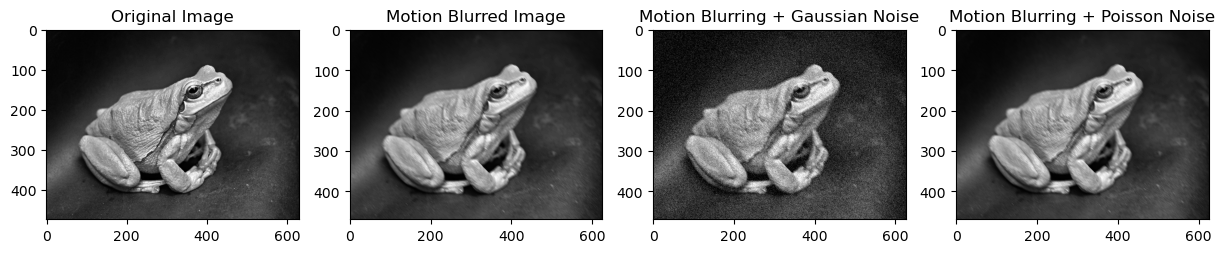

In [163]:
display = [img, blurred_img, noisy_img,noisy_img2]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Motion Blurring + Poisson Noise']

fig = plt.figure(figsize=(15, 5))  # Adjust the figsize for a horizontal layout

for i in range(len(display)):
    fig.add_subplot(1, 4, i+1)  # Set 1 row and 3 columns
    plt.imshow(display[i], cmap='gray')
    plt.title(label[i])

plt.show()


Direct Inverse Filter applied

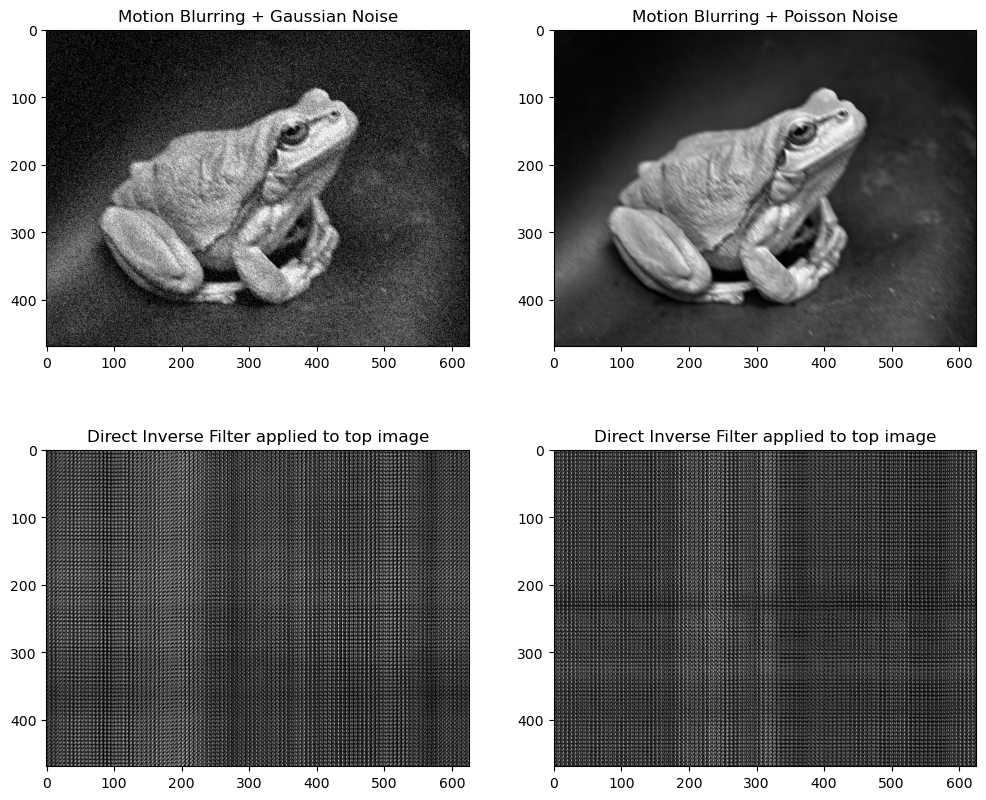

In [189]:
display = [ noisy_img, noisy_img2,  inv_filtered_img,inv_filtered_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Direct Inverse Filter applied to top image', 'Direct Inverse Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Truncated Inverse Filter applied

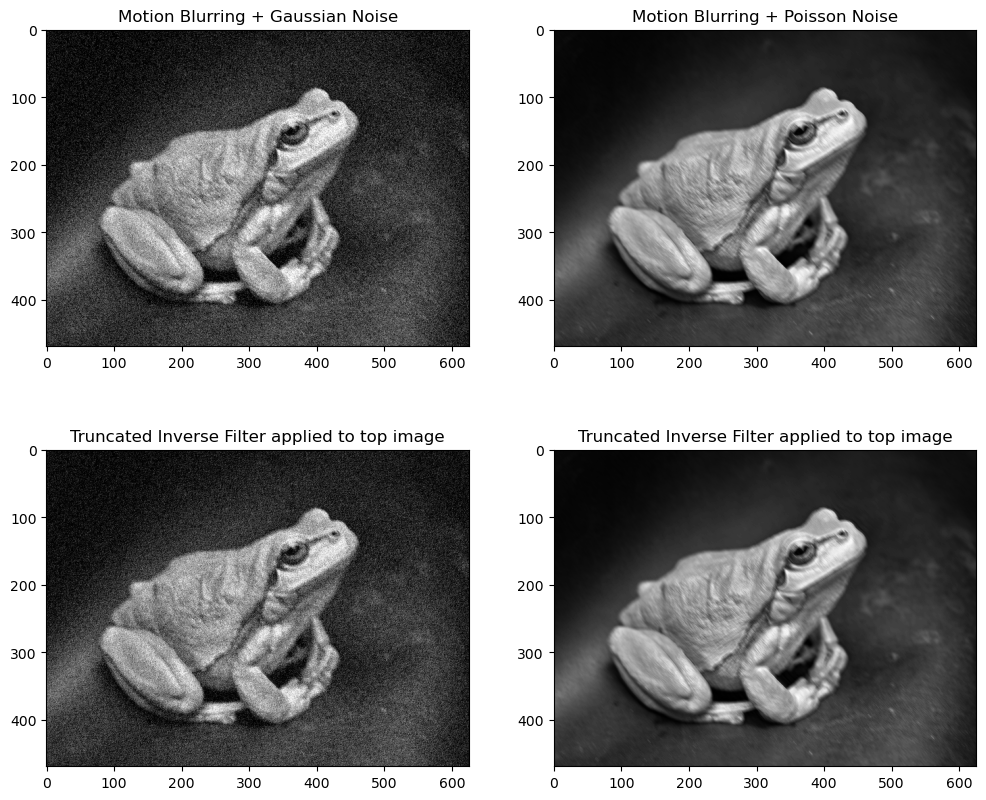

In [188]:
display = [img, blurred_img, noisy_img, trunc_inv_img]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Truncated Inverse Filter applied']

display = [  noisy_img, noisy_img2,  trunc_inv_img, trunc_inv_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Truncated Inverse Filter applied to top image', 'Truncated Inverse Filter applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Wiener Filter applied

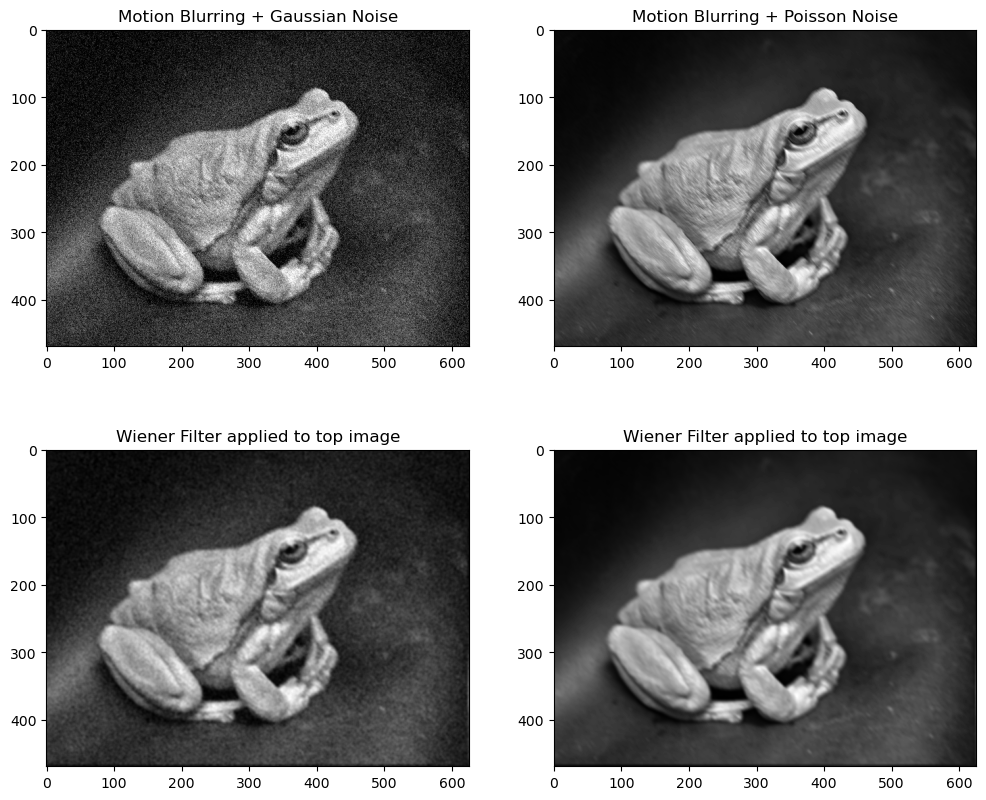

In [190]:


display = [ noisy_img, noisy_img2,  w_filtered_img,w_filtered_img2]
label = ['Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Wiener Filter applied to top image', 'Wiener Filter applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Richardson-Lucy Algorithm Applied 

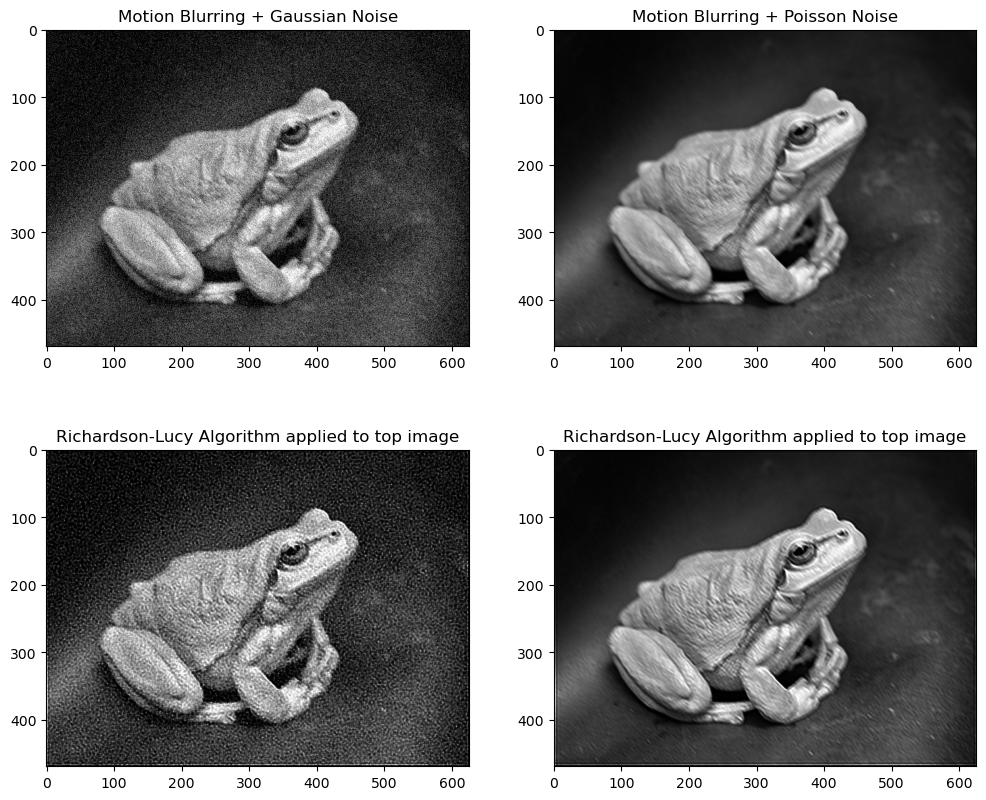

In [192]:
rl_img =  rl(noisy_img, kernel, 15) 
rl_img2 = rl(noisy_img2, kernel, 15)


display = [ noisy_img, noisy_img2,  rl_img,rl_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Richardson-Lucy Algorithm applied to top image', 'Richardson-Lucy Algorithm applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Code in Calculating PSNR and SSIM for the applied filters

In [194]:
# # img_np = img.detach().cpu().numpy()  # Original image
# # w_filtered_img_np = w_filtered_img.detach().cpu().numpy()  # Restored image
# print("Inverse Filtered Image Shape:", trunc_inv_img.shape)
# rl_img = richardson_lucy(noisy_img,kernel, 2)



# resizing the restored images so the psnr and ssim can be calculated
inv_filtered_img = resize(inv_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
trunc_inv_img = resize(trunc_inv_img, img.shape, mode='reflect', anti_aliasing=True)
w_filtered_img = resize(w_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
rl_img = resize(rl_img, img.shape, mode='reflect', anti_aliasing=True)

# resizing the restored images so the psnr and ssim can be calculated
inv_filtered_img2 = resize(inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
trunc_inv_img2 = resize(trunc_inv_img2, img.shape, mode='reflect', anti_aliasing=True)
w_filtered_img2 = resize(w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
rl_img2 = resize(rl_img2, img.shape, mode='reflect', anti_aliasing=True)

# If your images are in the range [0, 255]
data_range = 255.0

# Calculate PSNR for Motion blur + Gaussian Noise
inv_filtered_psnr_value = peak_signal_noise_ratio(img, inv_filtered_img, data_range=data_range)
trunc_inv_psnr_value = peak_signal_noise_ratio(img, trunc_inv_img, data_range=data_range)
w_psnr_value = peak_signal_noise_ratio(img, w_filtered_img, data_range=data_range)
rl_psnr_value = peak_signal_noise_ratio(img, rl_img, data_range=data_range)

# Calculate PSNR for Motion blur +  Poisspm Noise
inv_filtered_psnr_value2 = peak_signal_noise_ratio(img, inv_filtered_img2, data_range=data_range)
trunc_inv_psnr_value2 = peak_signal_noise_ratio(img, trunc_inv_img2, data_range=data_range)
w_psnr_value2 = peak_signal_noise_ratio(img, w_filtered_img2, data_range=data_range)
rl_psnr_value2 = peak_signal_noise_ratio(img, rl_img2, data_range=data_range)

# Calculate SSIM for Motion blur + Gaussian Noise
inv_ssim = structural_similarity(img, inv_filtered_img, data_range=data_range)
trunc_inv_ssim = structural_similarity(img, trunc_inv_img, data_range=data_range)
w_ssim =  structural_similarity(img, w_filtered_img, data_range=data_range)
rl_ssim = structural_similarity(img, rl_img, data_range=data_range)

# Calculate SSIM for Motion blur + Poisson Noise
inv_ssim2 = structural_similarity(img, inv_filtered_img, data_range=data_range)
trunc_inv_ssim2 = structural_similarity(img, trunc_inv_img, data_range=data_range)
w_ssim2 =  structural_similarity(img, w_filtered_img, data_range=data_range)
rl_ssim2 = structural_similarity(img, rl_img, data_range=data_range)





# # Check shapes
# print("Original Image Shape:", img.shape)
# print("Truncated Inverse Filtered Image Shape:", trunc_inv_img.shape)
# print("Wiener Filtered Image Shape:", w_filtered_img_resized.shape)

In [196]:
# printing PSNR for Filters applied to Motion Blur + Gaussian Noise
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{inv_filtered_psnr_value:.5f}")
print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value:.5f}")
print(f"Wiener Inverse Filter PSNR: {w_psnr_value:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {rl_psnr_value:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter PSNR:{inv_ssim:.5f}")
print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim:.5f}")
print(f"Wiener Inverse Filter PSNR: {w_ssim:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {rl_ssim:.5f}")



PSNR Values
Direct Inverse Filter PSNR:-23.00013
Truncated Inverse Filter PSNR:9.36506
Wiener Inverse Filter PSNR: 9.33179
Richardson Lucy Algorithm PSNR: 9.3651

SSIM Values
Direct Inverse Filter PSNR:0.00001
Truncated Inverse Filter PSNR:0.01802
Wiener Inverse Filter PSNR: 0.01246
Richardson Lucy Algorithm PSNR: 0.01792


In [198]:
# printing PSNR for Filters applied to Motion Blur + Poisson Noise
print("Motion Blur + Poisson Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{inv_filtered_psnr_value2:.5f}")
print(f"Truncated Inverse Filter PSNR:{trunc_inv_psnr_value2:.5f}")
print(f"Wiener Inverse Filter PSNR: {w_psnr_value2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {rl_psnr_value2:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Poisson Noise
print("SSIM Values")
print(f"Direct Inverse Filter PSNR:{inv_ssim2:.5f}")
print(f"Truncated Inverse Filter PSNR:{trunc_inv_ssim2:.5f}")
print(f"Wiener Inverse Filter PSNR: {w_ssim2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {rl_ssim2:.5f}")



PSNR Values
Direct Inverse Filter PSNR:-2.51363
Truncated Inverse Filter PSNR:9.36495
Wiener Inverse Filter PSNR: 9.33179
Richardson Lucy Algorithm PSNR: 9.3651

SSIM Values
Direct Inverse Filter PSNR:0.00001
Truncated Inverse Filter PSNR:0.01802
Wiener Inverse Filter PSNR: 0.01246
Richardson Lucy Algorithm PSNR: 0.01792
